_Lambda School Data Science — Big Data_

# AWS SageMaker

### Links

#### AWS
- The Open Guide to Amazon Web Services: EC2 Basics _(just this one short section!)_ https://github.com/open-guides/og-aws#ec2-basics
- AWS in Plain English https://www.expeditedssl.com/aws-in-plain-english
- Amazon SageMaker » Create an Amazon SageMaker Notebook Instance https://docs.aws.amazon.com/sagemaker/latest/dg/gs-setup-working-env.html
- Amazon SageMaker » Install External Libraries https://docs.aws.amazon.com/sagemaker/latest/dg/nbi-add-external.html 

`conda install -n python3 bokeh dask datashader fastparquet numba python-snappy`

#### Dask
- Why Dask? https://docs.dask.org/en/latest/why.html
- Use Cases https://docs.dask.org/en/latest/use-cases.html
- User Interfaces https://docs.dask.org/en/latest/user-interfaces.html

#### Numba
- A ~5 minute guide http://numba.pydata.org/numba-doc/latest/user/5minguide.html

## 1. Estimate pi
https://en.wikipedia.org/wiki/Approximations_of_π#Summing_a_circle's_area

### With plain Python

In [1]:
# These will be my notes
import random

def monte_carlo_pi(nsamples):
    acc = 0
    for _ in range(int(nsamples)):
        x = random.random()
        y = random.random()
        if (x**2 + y**2) < 1.0:
            acc += 1
    return 4.0 * acc / nsamples

In [2]:
%%time
monte_carlo_pi(1e7)

CPU times: user 4.17 s, sys: 0 ns, total: 4.17 s
Wall time: 4.17 s


3.1411092

### With Numba
http://numba.pydata.org/

In [3]:
from numba import jit

In [8]:
@jit(nopython=True)
def monte_carlo_pi(nsamples):
    acc = 0
    for _ in range(int(nsamples)):
        x = random.random()
        y = random.random()
        if (x**2 + y**2) < 1.0:
            acc += 1
    return 4.0 * acc / nsamples

In [13]:
%time
monte_carlo_pi(1e7)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.63 µs


3.1414004

## 2. Loop a slow function

### With plain Python

In [14]:
from time import sleep

def slow_square(x):
    sleep(1)
    return x**2

In [15]:
%%time
[slow_square(n) for n in range(16)]

CPU times: user 1.69 ms, sys: 253 µs, total: 1.94 ms
Wall time: 16 s


[0, 1, 4, 9, 16, 25, 36, 49, 64, 81, 100, 121, 144, 169, 196, 225]

### With Dask
- https://examples.dask.org/delayed.html
- http://docs.dask.org/en/latest/setup/single-distributed.html

In [16]:
from dask import compute, delayed

In [21]:
%time
compute(delayed(slow_square)(n) for n in range(16))[0]

CPU times: user 0 ns, sys: 5 µs, total: 5 µs
Wall time: 10.3 µs


[0, 1, 4, 9, 16, 25, 36, 49, 64, 81, 100, 121, 144, 169, 196, 225]

## 3. Analyze millions of Instacart orders

### Download data
https://tech.instacart.com/3-million-instacart-orders-open-sourced-d40d29ead6f2

In [22]:
!wget https://s3.amazonaws.com/instacart-datasets/instacart_online_grocery_shopping_2017_05_01.tar.gz

--2019-06-10 18:52:11--  https://s3.amazonaws.com/instacart-datasets/instacart_online_grocery_shopping_2017_05_01.tar.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.162.181
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.162.181|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 205548478 (196M) [application/x-gzip]
Saving to: ‘instacart_online_grocery_shopping_2017_05_01.tar.gz’

instacart_online_gr 100%[===================>] 196.03M  38.2MB/s    in 5.6s    

2019-06-10 18:52:17 (35.0 MB/s) - ‘instacart_online_grocery_shopping_2017_05_01.tar.gz’ saved [205548478/205548478]



In [23]:
!tar --gunzip --extract --verbose --file=instacart_online_grocery_shopping_2017_05_01.tar.gz

instacart_2017_05_01/
instacart_2017_05_01/._aisles.csv
instacart_2017_05_01/aisles.csv
instacart_2017_05_01/._departments.csv
instacart_2017_05_01/departments.csv
instacart_2017_05_01/._order_products__prior.csv
instacart_2017_05_01/order_products__prior.csv
instacart_2017_05_01/._order_products__train.csv
instacart_2017_05_01/order_products__train.csv
instacart_2017_05_01/._orders.csv
instacart_2017_05_01/orders.csv
instacart_2017_05_01/._products.csv
instacart_2017_05_01/products.csv


In [24]:
%cd instacart_2017_05_01

/home/ec2-user/SageMaker/DS-Unit-3-Sprint-3-Big-Data/module1-aws-sagemaker/instacart_2017_05_01


In [25]:
!ls -lh *.csv

-rw-r--r-- 1 ec2-user ec2-user 2.6K May  2  2017 aisles.csv
-rw-r--r-- 1 ec2-user ec2-user  270 May  2  2017 departments.csv
-rw-r--r-- 1 ec2-user ec2-user 551M May  2  2017 order_products__prior.csv
-rw-r--r-- 1 ec2-user ec2-user  24M May  2  2017 order_products__train.csv
-rw-r--r-- 1 ec2-user ec2-user 104M May  2  2017 orders.csv
-rw-r--r-- 1 ec2-user ec2-user 2.1M May  2  2017 products.csv


### With Pandas

#### Load & merge data

In [26]:
import pandas as pd

In [27]:
%%time
order_products = pd.concat([
    pd.read_csv('order_products__prior.csv'), 
    pd.read_csv('order_products__train.csv')])

order_products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33819106 entries, 0 to 1384616
Data columns (total 4 columns):
order_id             int64
product_id           int64
add_to_cart_order    int64
reordered            int64
dtypes: int64(4)
memory usage: 1.3 GB
CPU times: user 9.61 s, sys: 2.06 s, total: 11.7 s
Wall time: 11.8 s


In [28]:
order_products.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [29]:
products = pd.read_csv('products.csv')
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 4 columns):
product_id       49688 non-null int64
product_name     49688 non-null object
aisle_id         49688 non-null int64
department_id    49688 non-null int64
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


In [30]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [31]:
%%time
order_products = pd.merge(order_products, products[['product_id', 'product_name']])

CPU times: user 5.93 s, sys: 1.68 s, total: 7.61 s
Wall time: 7.6 s


In [32]:
order_products.head()

,order_id,product_id,add_to_cart_order,reordered,product_name
0,2,33120,1,1,Organic Egg Whites
1,26,33120,5,0,Organic Egg Whites
2,120,33120,13,0,Organic Egg Whites
3,327,33120,5,1,Organic Egg Whites
4,390,33120,28,1,Organic Egg Whites


#### Most popular products?

In [35]:
%time
order_products['product_name'].value_counts()[:10]

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 8.82 µs


Banana                    491291
Bag of Organic Bananas    394930
Organic Strawberries      275577
Organic Baby Spinach      251705
Organic Hass Avocado      220877
Organic Avocado           184224
Large Lemon               160792
Strawberries              149445
Limes                     146660
Organic Whole Milk        142813
Name: product_name, dtype: int64

#### Organic?

In [36]:
%time
order_products['organic'] = order_products['product_name'].str.contains('Organic')

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 9.06 µs


In [38]:
%time
order_products['organic'].value_counts(normalize=True)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 9.3 µs


False    0.684912
True     0.315088
Name: organic, dtype: float64

### With Dask
https://examples.dask.org/dataframe.html

In [11]:
import dask.dataframe as dd
from dask.distributed import Client

#### Load & merge data
https://examples.dask.org/dataframes/01-data-access.html#Read-CSV-files

In [40]:
%%time
order_products = dd.read_csv('order_products*.csv')

CPU times: user 17.9 ms, sys: 222 µs, total: 18.1 ms
Wall time: 17 ms


In [41]:
%%time
order_products = dd.merge(order_products, products[['product_id', 'product_name']])

CPU times: user 20.5 ms, sys: 569 µs, total: 21.1 ms
Wall time: 19.8 ms


http://docs.dask.org/en/latest/dataframe-performance.html#persist-intelligently

In [42]:
order_products.head()

,order_id,product_id,add_to_cart_order,reordered,product_name
0,2,33120,1,1,Organic Egg Whites
1,26,33120,5,0,Organic Egg Whites
2,120,33120,13,0,Organic Egg Whites
3,327,33120,5,1,Organic Egg Whites
4,390,33120,28,1,Organic Egg Whites


#### Most popular products?

In [43]:
%%time
order_products['product_name'].value_counts().compute()[:10]

CPU times: user 20.5 s, sys: 3.63 s, total: 24.2 s
Wall time: 8.49 s


Banana                    491291
Bag of Organic Bananas    394930
Organic Strawberries      275577
Organic Baby Spinach      251705
Organic Hass Avocado      220877
Organic Avocado           184224
Large Lemon               160792
Strawberries              149445
Limes                     146660
Organic Whole Milk        142813
Name: product_name, dtype: int64

#### Organic?

In [44]:
%%time
order_products['organic'] = order_products['product_name'].str.contains('Organic')

CPU times: user 8.27 ms, sys: 22 µs, total: 8.29 ms
Wall time: 7.47 ms


In [45]:
%%time
order_products['organic'].value_counts().compute()

CPU times: user 35.2 s, sys: 3.55 s, total: 38.8 s
Wall time: 21.6 s


False    23163118
True     10655988
Name: organic, dtype: int64

## 4. Fit a machine learning model

### Load data

In [47]:
%cd ../ds-predictive-modeling-challenge-data

/home/ec2-user/SageMaker/DS-Unit-3-Sprint-3-Big-Data/module1-aws-sagemaker/ds-predictive-modeling-challenge-data


In [48]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

train_features = pd.read_csv('train_features.csv')
train_labels = pd.read_csv('train_labels.csv')

X_train_numeric = train_features.select_dtypes(np.number)
y_train = train_labels['status_group']

### With 2 cores (like Google Colab)
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [50]:
%%time
model = RandomForestClassifier(n_estimators=200, oob_score=True, n_jobs=2, random_state=42, verbose=1)
model.fit(X_train_numeric, y_train)
print('Out-of-bag score:', model.oob_score_)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.7s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   11.5s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:   11.8s finished


Out-of-bag score: 0.7206228956228956
CPU times: user 25.2 s, sys: 225 ms, total: 25.5 s
Wall time: 13.7 s


### With 16 cores (on AWS m4.4xlarge)

In [53]:
%%time
model = RandomForestClassifier(n_estimators=200, oob_score=True, n_jobs=-1, random_state=42, verbose=1)
model.fit(X_train_numeric, y_train)
print('Out-of-bag score:', model.oob_score_)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    2.4s finished


Out-of-bag score: 0.7206228956228956
CPU times: user 37.5 s, sys: 184 ms, total: 37.7 s
Wall time: 4.28 s


## ASSIGNMENT

Revisit a previous assignment or project that had slow speeds or big data.

Make it better with what you've learned today!

You can use `wget` or Kaggle API to get data. Some possibilities include:

- https://www.kaggle.com/c/ds1-predictive-modeling-challenge
- https://www.kaggle.com/ntnu-testimon/paysim1
- https://github.com/mdeff/fma
- https://tech.instacart.com/3-million-instacart-orders-open-sourced-d40d29ead6f2 



Also, you can play with [Datashader](http://datashader.org/) and its [example datasets](https://github.com/pyviz/datashader/blob/master/examples/datasets.yml)!

In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


In [2]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    %matplotlib inline
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show();
    
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show();
    
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show();
                

In [4]:
nRowsRead = 1000

chem_df = pd.read_csv('chem.csv', nrows = nRowsRead)
practices_df = pd.read_csv('practices.csv', nrows = nRowsRead)
df3 = pd.read_csv('T201605PDPI+BNFT.csv', delimiter=',', nrows = nRowsRead)

In [5]:
chem_df.head()

,CHEM SUB,NAME
0,0101010A0,Alexitol Sodium
1,0101010B0,Almasilate
2,0101010C0,Aluminium Hydroxide
3,0101010D0,Aluminium Hydroxide With Magnesium
4,0101010E0,Hydrotalcite


In [6]:
chem_df.shape

(1000, 2)

In [7]:
plotPerColumnDistribution(chem_df, 10, 5)

<Figure size 2400x512 with 0 Axes>

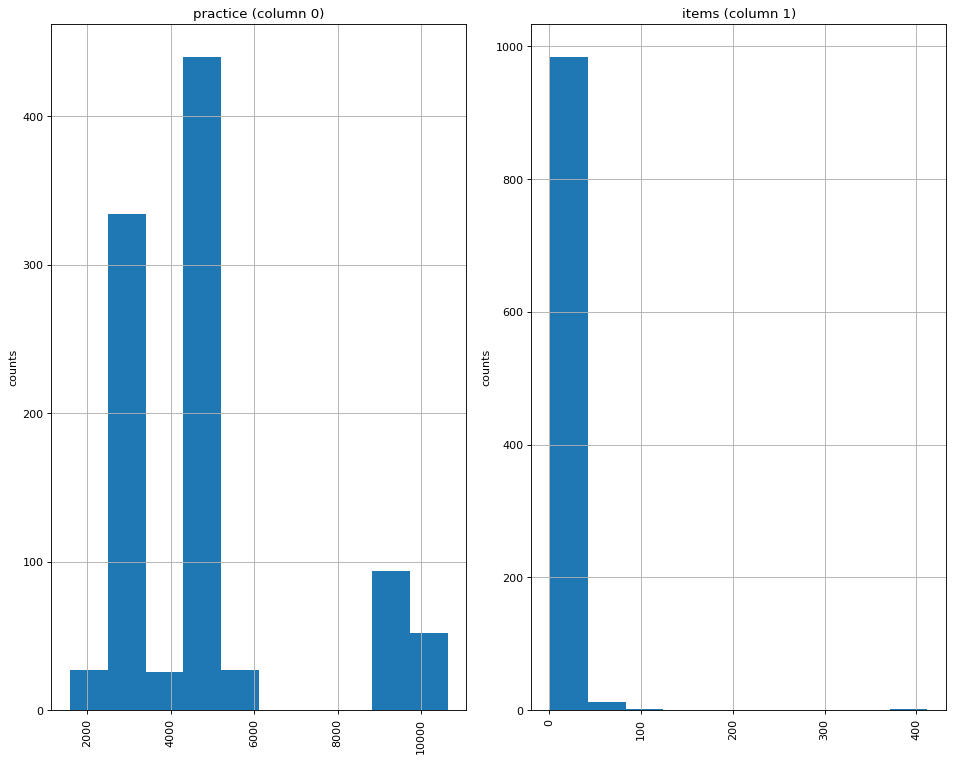

In [8]:
plotPerColumnDistribution(df3, 10, 5)

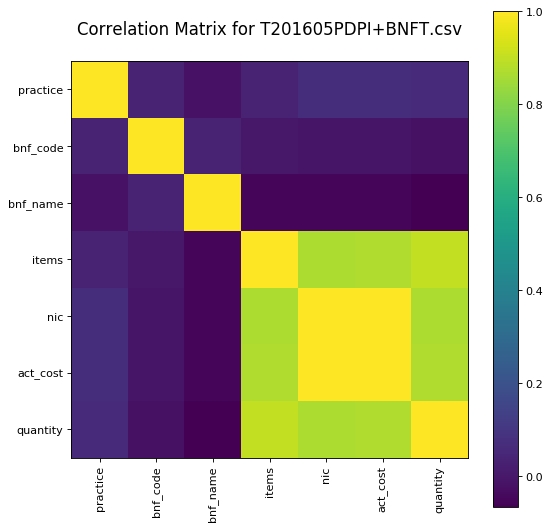

In [9]:
df3.dataframeName = 'T201605PDPI+BNFT.csv'
plotCorrelationMatrix(df3, 8)

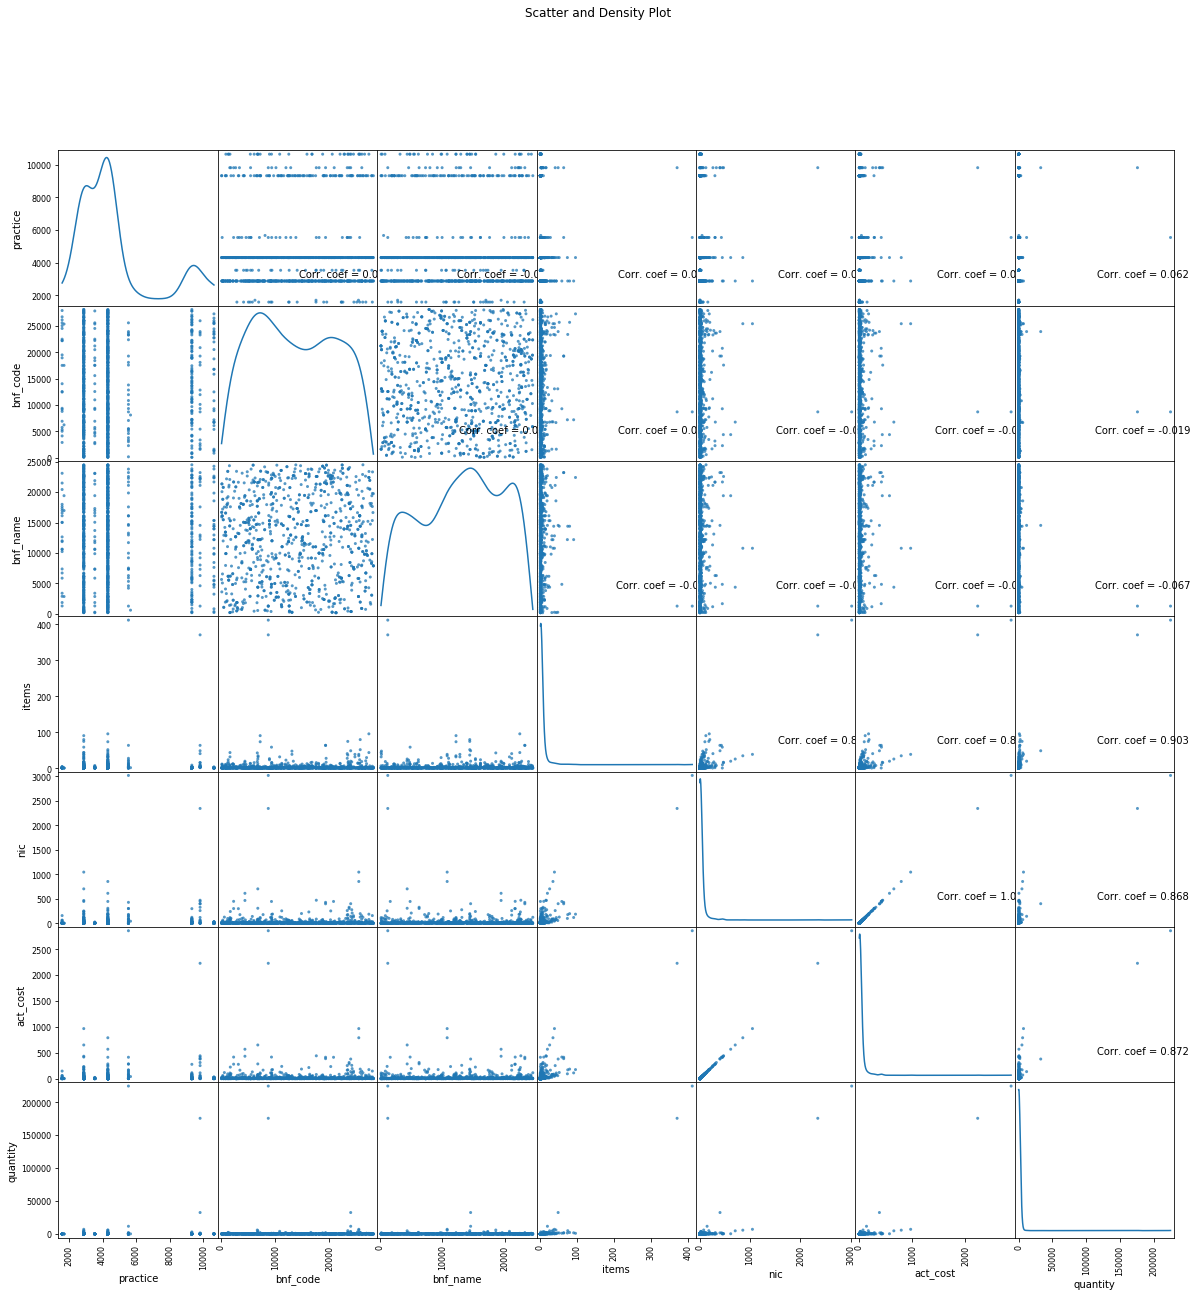

In [10]:
plotScatterMatrix(df3, 20, 10)

In [18]:
%%time
dd3 = dd.read_csv('T201605PDPI+BNFT.csv', delimiter=',')


CPU times: user 19.8 ms, sys: 0 ns, total: 19.8 ms
Wall time: 18.7 ms


In [14]:
%%time
df3 = pd.read_csv('T201605PDPI+BNFT.csv', delimiter=',', )

CPU times: user 5.97 s, sys: 808 ms, total: 6.78 s
Wall time: 6.77 s
